In [2]:
pip install pytorch_spiking

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import time
import pytorch_spiking

torch.manual_seed(0)
np.random.seed(0)

100%|██████████| 26421880/26421880 [00:02<00:00, 11115627.75it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210574.19it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3904719.48it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13912549.61it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



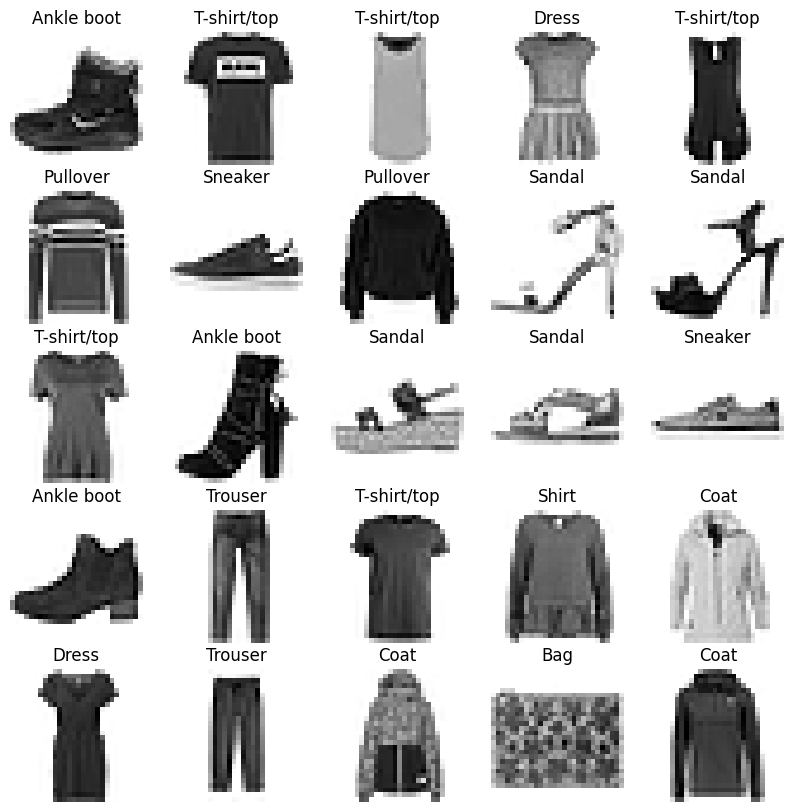

In [4]:
train_pictures, train_labels = zip(
    *torchvision.datasets.FashionMNIST(".", train=True, download=True)
)
train_pictures = np.asarray([np.array(pic) for pic in train_pictures], dtype=np.float32)
train_labels = np.asarray(train_labels, dtype=np.int64)
test_pictures, test_labels = zip(
    *torchvision.datasets.FashionMNIST(".", train=False, download=True)
)
test_pictures = np.asarray([np.array(pic) for pic in train_pictures], dtype=np.float32)
test_labels = np.asarray(train_labels, dtype=np.int64)

# normalize images so values are between 0 and 1
train_pictures = train_pictures / 255.0
test_pictures = test_pictures / 255.0

class_labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
num_classes = len(class_labels)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_pictures[i], cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_labels[train_labels[i]])

In [5]:
def train(input_ssn, train_x, test_x):
    minibatch_size = 32
    optimizer = torch.optim.AdamW(input_ssn.parameters())
    s = time.time()
    input_ssn.train()

    # Initialize variables for early stopping
    patience = 5
    best_loss = float('inf')
    best_epoch = 0
    early_stop = False

    for j in range(50):
        train_acc = 0
        for i in range(train_x.shape[0] // minibatch_size):
            input_ssn.zero_grad()

            input_batch = train_x[i * minibatch_size : (i + 1) * minibatch_size]
            # flatten images
            input_batch = input_batch.reshape((-1,) + train_x.shape[1:-2] + (784,))
            batch_label = train_labels[i * minibatch_size : (i + 1) * minibatch_size]
            output = input_ssn(torch.tensor(input_batch))

            # compute sparse categorical cross entropy loss
            logp = torch.nn.functional.log_softmax(output, dim=-1)
            logpy = torch.gather(logp, 1, torch.tensor(batch_label).view(-1, 1))
            loss = -logpy.mean()

            loss.backward()#bptt
            optimizer.step()

            train_acc += torch.mean(
                torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
            )

        train_acc /= i + 1
        print(f"Accuracy(Training) ({j}): {train_acc.numpy()}")

        # Check if the loss has improved for early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = j
        elif j - best_epoch > patience:
            print("Early stopping due to no improvement in loss.")
            early_stop = True
            break

    train_time= time.time() - s
    print("Training time:",train_time)


        # compute test accuracy
    s1=time.time()
    input_ssn.eval()
    test_acc = 0
    for i in range(test_x.shape[0] // minibatch_size):
            input_batch = test_x[i * minibatch_size : (i + 1) * minibatch_size]
            input_batch = input_batch.reshape((-1,) + test_x.shape[1:-2] + (784,))
            batch_label = test_labels[i * minibatch_size : (i + 1) * minibatch_size]
            output = input_ssn(torch.tensor(input_batch))

            test_acc += torch.mean(
                torch.eq(torch.argmax(output, dim=1), torch.tensor(batch_label)).float()
            )

    test_acc /= i + 1

    print(f"Accuracy(Testing) {test_acc.numpy()}")


In [11]:
# repeat the images for n_steps
n_steps = 10
train_stream = np.tile(train_pictures[:, None], (1, n_steps, 1, 1))
test_stream = np.tile(test_pictures[:, None], (1, n_steps, 1, 1))

In [ ]:
spiking_model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # wrap ReLU in SpikingActivation
    pytorch_spiking.SpikingActivation(torch.nn.ReLU(), spiking_aware_training=False),
    # use average pooling layer to average spiking output over time
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

# train the model, identically to the non-spiking version,
# except using the time sequences as input
train(spiking_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8066999912261963
Accuracy(Training) (1): 0.8263833522796631
Accuracy(Training) (2): 0.8268666863441467
Accuracy(Training) (3): 0.8294333219528198
Accuracy(Training) (4): 0.8267666697502136
Accuracy(Training) (5): 0.826116681098938
Accuracy(Training) (6): 0.8269500136375427
Accuracy(Training) (7): 0.8227499723434448
Accuracy(Training) (8): 0.8268166780471802
Accuracy(Training) (9): 0.8291166424751282
Training time: 54.03077745437622
Accuracy(Testing) 0.19359999895095825
Testing/Simulation time 56.325156688690186


In [ ]:
spiking_model = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # wrap ReLU in SpikingActivation
    pytorch_spiking.SpikingActivation(torch.nn.ReLU(), spiking_aware_training=True),
    # use average pooling layer to average spiking output over time
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

# train the model, identically to the non-spiking version,
# except using the time sequences as input
train(spiking_model, train_stream, test_stream)

Accuracy(Training) (0): 0.41624999046325684
Accuracy(Training) (1): 0.5302000045776367
Accuracy(Training) (2): 0.5817000269889832
Accuracy(Training) (3): 0.6181666851043701
Accuracy(Training) (4): 0.6381499767303467
Accuracy(Training) (5): 0.6545833349227905
Accuracy(Training) (6): 0.6656833291053772
Accuracy(Training) (7): 0.6744333505630493
Accuracy(Training) (8): 0.6825000047683716
Accuracy(Training) (9): 0.6916666626930237
Training time: 58.61360764503479
Accuracy(Testing) 0.7085333466529846
Testing/Simulation time 61.41812181472778


In [ ]:
spikeaware_model1= torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.Sigmoid(), dt=0.01, spiking_aware_training=True
    ),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model1, train_stream, test_stream)

Accuracy(Training) (0): 0.5287666916847229
Accuracy(Training) (1): 0.6205333471298218
Accuracy(Training) (2): 0.6396499872207642
Accuracy(Training) (3): 0.647183358669281
Accuracy(Training) (4): 0.6565499901771545
Accuracy(Training) (5): 0.6610000133514404
Accuracy(Training) (6): 0.6669666767120361
Accuracy(Training) (7): 0.668666660785675
Accuracy(Training) (8): 0.6713333129882812
Accuracy(Training) (9): 0.6736999750137329
Training time: 58.632429361343384
Accuracy(Testing) 0.6780166625976562
Testing/Simulation time 61.50780534744263


In [7]:
class SelfAttention(torch.nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = torch.nn.Linear(input_dim, input_dim)
        self.key = torch.nn.Linear(input_dim, input_dim)
        self.value = torch.nn.Linear(input_dim, input_dim)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        attn_weights = torch.nn.functional.softmax(q @ k.transpose(-2, -1), dim=-1)
        return attn_weights @ v

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.GELU(), spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.ELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.GELU(), spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.5613333582878113
Accuracy(Training) (1): 0.6422333121299744
Accuracy(Training) (2): 0.65788334608078
Accuracy(Training) (3): 0.6605166792869568
Accuracy(Training) (4): 0.6609833240509033
Accuracy(Training) (5): 0.6607000231742859
Accuracy(Training) (6): 0.6540499925613403
Early stopping due to no improvement in loss.
Training time: 322.35853600502014
Accuracy(Testing) 0.6847500205039978


In [ ]:
spiking_model2 = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.Dropout(0.5),
    # wrap ReLU in SpikingActivation
    pytorch_spiking.SpikingActivation(torch.nn.GELU(), spiking_aware_training=True),
    SelfAttention(256),
    torch.nn.Linear(256, 128),
    torch.nn.SiLU(),
    # use average pooling layer to average spiking output over time
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

# train the model, identically to the non-spiking version,
# except using the time sequences as input
train(spiking_model2, train_stream, test_stream)

Accuracy(Training) (0): 0.14470000565052032
Accuracy(Training) (1): 0.19398333132266998
Accuracy(Training) (2): 0.22706666588783264
Accuracy(Training) (3): 0.2568666636943817
Accuracy(Training) (4): 0.2722499966621399
Accuracy(Training) (5): 0.27285000681877136
Accuracy(Training) (6): 0.2851499915122986
Accuracy(Training) (7): 0.28476667404174805
Accuracy(Training) (8): 0.28931665420532227
Accuracy(Training) (9): 0.28868332505226135
Accuracy(Training) (10): 0.2937833368778229
Accuracy(Training) (11): 0.2984166741371155
Accuracy(Training) (12): 0.3010999858379364
Accuracy(Training) (13): 0.29386666417121887


KeyboardInterrupt: ignored

In [ ]:
spiking_model2 = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.Dropout(0.5),
    SelfAttention(256),
    torch.nn.Linear(256, 128),
    torch.nn.SiLU(),
    pytorch_spiking.SpikingActivation(torch.nn.SiLU(), spiking_aware_training=True),
    # use average pooling layer to average spiking output over time
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

# train the model, identically to the non-spiking version,
# except using the time sequences as input
train(spiking_model2, train_stream, test_stream)

Accuracy(Training) (0): 0.5889833569526672
Accuracy(Training) (1): 0.6851999759674072
Accuracy(Training) (2): 0.7137166857719421
Accuracy(Training) (3): 0.7252500057220459
Accuracy(Training) (4): 0.7479000091552734
Accuracy(Training) (5): 0.7391999959945679
Accuracy(Training) (6): 0.7612000107765198
Accuracy(Training) (7): 0.7760166525840759
Accuracy(Training) (8): 0.77756667137146
Accuracy(Training) (9): 0.7882833480834961
Accuracy(Training) (10): 0.7865999937057495
Accuracy(Training) (11): 0.7933666706085205
Accuracy(Training) (12): 0.7950500249862671
Accuracy(Training) (13): 0.7942666411399841
Accuracy(Training) (14): 0.796833336353302
Accuracy(Training) (15): 0.7912833094596863
Accuracy(Training) (16): 0.7990999817848206
Accuracy(Training) (17): 0.8058666586875916
Accuracy(Training) (18): 0.8060166835784912
Accuracy(Training) (19): 0.8062333464622498
Accuracy(Training) (20): 0.7977833151817322
Accuracy(Training) (21): 0.8074666857719421
Accuracy(Training) (22): 0.810699999332428
Ac

In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
     pytorch_spiking.SpikingActivation(torch.nn.ELU(), spiking_aware_training=True),
    torch.nn.Linear(256,128),
    torch.nn.GELU(),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.6371999979019165
Accuracy(Training) (1): 0.7202000021934509
Accuracy(Training) (2): 0.7486000061035156
Accuracy(Training) (3): 0.7564166784286499
Accuracy(Training) (4): 0.7615500092506409
Accuracy(Training) (5): 0.7684666514396667
Accuracy(Training) (6): 0.7630166411399841
Accuracy(Training) (7): 0.7622166872024536
Early stopping due to no improvement in loss.
Training time: 433.44601798057556
Accuracy(Testing) 0.7289999723434448


In [ ]:
spiking_model2 = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    torch.nn.Dropout(0.5),
    # wrap ReLU in SpikingActivation
    pytorch_spiking.SpikingActivation(torch.nn.GELU(), spiking_aware_training=True),
    SelfAttention(256),
    torch.nn.Linear(256, 128),
    torch.nn.SiLU(),
    pytorch_spiking.SpikingActivation(torch.nn.SiLU(), spiking_aware_training=True),
    # use average pooling layer to average spiking output over time
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)

# train the model, identically to the non-spiking version,
# except using the time sequences as input
train(spiking_model2, train_stream, test_stream)

Accuracy(Training) (0): 0.125083327293396
Accuracy(Training) (1): 0.1428833305835724
Accuracy(Training) (2): 0.16698333621025085
Accuracy(Training) (3): 0.20956666767597198
Accuracy(Training) (4): 0.2233666628599167
Accuracy(Training) (5): 0.22281666100025177
Accuracy(Training) (6): 0.2303166687488556
Accuracy(Training) (7): 0.24120000004768372
Accuracy(Training) (8): 0.259799987077713
Accuracy(Training) (9): 0.2653833329677582
Accuracy(Training) (10): 0.2662000060081482
Accuracy(Training) (11): 0.27506667375564575
Accuracy(Training) (12): 0.2837333381175995
Accuracy(Training) (13): 0.287283331155777
Accuracy(Training) (14): 0.2919333279132843
Accuracy(Training) (15): 0.3034000098705292
Accuracy(Training) (16): 0.30523332953453064
Accuracy(Training) (17): 0.30908334255218506
Accuracy(Training) (18): 0.3198666572570801
Accuracy(Training) (19): 0.3385666608810425
Accuracy(Training) (20): 0.35128334164619446
Accuracy(Training) (21): 0.35945001244544983
Accuracy(Training) (22): 0.369533330

In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.8101833462715149
Accuracy(Training) (1): 0.8468000292778015
Accuracy(Training) (2): 0.8591499924659729
Accuracy(Training) (3): 0.8686166405677795
Accuracy(Training) (4): 0.8758166432380676
Accuracy(Training) (5): 0.8809999823570251
Accuracy(Training) (6): 0.8860666751861572
Accuracy(Training) (7): 0.8898500204086304
Accuracy(Training) (8): 0.8935166597366333
Accuracy(Training) (9): 0.8966500163078308
Accuracy(Training) (10): 0.900600016117096
Accuracy(Training) (11): 0.902483344078064
Accuracy(Training) (12): 0.9052666425704956
Accuracy(Training) (13): 0.9075166583061218
Accuracy(Training) (14): 0.9097499847412109
Accuracy(Training) (15): 0.9117833375930786
Accuracy(Training) (16): 0.9143000245094299
Accuracy(Training) (17): 0.914816677570343
Accuracy(Training) (18): 0.9164666533470154
Accuracy(Training) (19): 0.9189500212669373
Accuracy(Training) (20): 0.9207666516304016
Accuracy(Training) (21): 0.9233166575431824
Accuracy(Training) (22): 0.9230166673660278
A

In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.SiLU(), dt=0.05, spiking_aware_training=True
    ),
    torch.nn.Linear(256,128),
     SelfAttention(128),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.7043333053588867
Accuracy(Training) (1): 0.7181833386421204
Accuracy(Training) (2): 0.745283305644989
Accuracy(Training) (3): 0.7432833313941956
Accuracy(Training) (4): 0.765749990940094
Accuracy(Training) (5): 0.7668499946594238
Accuracy(Training) (6): 0.7876833081245422
Accuracy(Training) (7): 0.7859500050544739
Accuracy(Training) (8): 0.7879166603088379
Accuracy(Training) (9): 0.7957166433334351
Accuracy(Training) (10): 0.7996833324432373
Accuracy(Training) (11): 0.8112166523933411
Accuracy(Training) (12): 0.812666654586792
Accuracy(Training) (13): 0.8170333504676819
Accuracy(Training) (14): 0.8199666738510132
Accuracy(Training) (15): 0.8057833313941956
Accuracy(Training) (16): 0.821066677570343
Early stopping due to no improvement in loss.
Training time: 284.274671792984
Accuracy(Testing) 0.8075000047683716


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
     SelfAttention(128),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.7976833581924438
Accuracy(Training) (1): 0.834683358669281
Accuracy(Training) (2): 0.8426333069801331
Accuracy(Training) (3): 0.8514666557312012
Accuracy(Training) (4): 0.8585166931152344
Accuracy(Training) (5): 0.8639333248138428
Accuracy(Training) (6): 0.8638333082199097
Accuracy(Training) (7): 0.8696333169937134
Accuracy(Training) (8): 0.8738499879837036
Accuracy(Training) (9): 0.8733500242233276
Accuracy(Training) (10): 0.8782333135604858
Accuracy(Training) (11): 0.8814833164215088
Accuracy(Training) (12): 0.8798166513442993
Accuracy(Training) (13): 0.8804833292961121
Accuracy(Training) (14): 0.8828499913215637
Accuracy(Training) (15): 0.8840000033378601
Accuracy(Training) (16): 0.883899986743927
Accuracy(Training) (17): 0.8906333446502686
Accuracy(Training) (18): 0.8913499712944031
Accuracy(Training) (19): 0.8886500000953674
Early stopping due to no improvement in loss.
Training time: 334.71685123443604
Accuracy(Testing) 0.8852166533470154


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.PReLU(num_parameters=1, init=0.05), dt=0.05, spiking_aware_training=True #parametric ReLu
    ),
    torch.nn.Linear(256,128),
     SelfAttention(128),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.6921499967575073
Accuracy(Training) (1): 0.7208333611488342
Accuracy(Training) (2): 0.7499333620071411
Accuracy(Training) (3): 0.7479833364486694
Accuracy(Training) (4): 0.7708666920661926
Accuracy(Training) (5): 0.775433361530304
Accuracy(Training) (6): 0.788349986076355
Accuracy(Training) (7): 0.7928333282470703
Accuracy(Training) (8): 0.7960666418075562
Accuracy(Training) (9): 0.7944166660308838
Early stopping due to no improvement in loss.
Training time: 165.63849520683289
Accuracy(Testing) 0.8059499859809875


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(), dt=0.05, spiking_aware_training=True
    ),
    torch.nn.Linear(256,128),
     SelfAttention(128),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.7010999917984009
Accuracy(Training) (1): 0.7298333048820496
Accuracy(Training) (2): 0.7343500256538391
Accuracy(Training) (3): 0.756683349609375
Accuracy(Training) (4): 0.7757166624069214
Accuracy(Training) (5): 0.7788333296775818
Accuracy(Training) (6): 0.785183310508728
Accuracy(Training) (7): 0.7909333109855652
Accuracy(Training) (8): 0.8003333210945129
Accuracy(Training) (9): 0.8037833571434021
Accuracy(Training) (10): 0.8003333210945129
Accuracy(Training) (11): 0.8149333596229553
Accuracy(Training) (12): 0.8121833205223083
Accuracy(Training) (13): 0.8196666836738586
Accuracy(Training) (14): 0.8105166554450989
Accuracy(Training) (15): 0.8226833343505859
Accuracy(Training) (16): 0.8182166814804077
Accuracy(Training) (17): 0.8285999894142151
Accuracy(Training) (18): 0.8221499919891357
Accuracy(Training) (19): 0.8274000287055969
Accuracy(Training) (20): 0.8307499885559082
Accuracy(Training) (21): 0.8269166946411133
Accuracy(Training) (22): 0.8359500169754028


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
        SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(), dt=0.05, spiking_aware_training=True
    ),
    torch.nn.Linear(256,128),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.8036666512489319
Accuracy(Training) (1): 0.843916654586792
Accuracy(Training) (2): 0.8532000184059143
Accuracy(Training) (3): 0.862333357334137
Accuracy(Training) (4): 0.8697166442871094
Accuracy(Training) (5): 0.8751166462898254
Accuracy(Training) (6): 0.8787833452224731
Accuracy(Training) (7): 0.8830166459083557
Accuracy(Training) (8): 0.8865166902542114
Accuracy(Training) (9): 0.8899000287055969
Accuracy(Training) (10): 0.8912000060081482
Accuracy(Training) (11): 0.894266664981842
Accuracy(Training) (12): 0.8968999981880188
Accuracy(Training) (13): 0.9005666375160217
Accuracy(Training) (14): 0.9016166925430298
Accuracy(Training) (15): 0.904116690158844
Accuracy(Training) (16): 0.9051499962806702
Accuracy(Training) (17): 0.9074666500091553
Accuracy(Training) (18): 0.9074000120162964
Accuracy(Training) (19): 0.9104666709899902
Accuracy(Training) (20): 0.9106833338737488
Accuracy(Training) (21): 0.9126333594322205
Accuracy(Training) (22): 0.9125999808311462
Ac

In [ ]:
spikeaware_model25 = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.Softplus(beta=1, threshold=10), dt=0.05, spiking_aware_training=True
    ),
    torch.nn.Linear(256,128),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10))
train(spikeaware_model25, train_stream, test_stream)

Accuracy(Training) (0): 0.8032166957855225
Accuracy(Training) (1): 0.8446499705314636
Accuracy(Training) (2): 0.8579000234603882
Accuracy(Training) (3): 0.868066668510437
Accuracy(Training) (4): 0.8750166893005371
Accuracy(Training) (5): 0.8801666498184204
Accuracy(Training) (6): 0.8841833472251892
Accuracy(Training) (7): 0.8887500166893005
Accuracy(Training) (8): 0.8921999931335449
Accuracy(Training) (9): 0.8949666619300842
Accuracy(Training) (10): 0.8977333307266235
Accuracy(Training) (11): 0.8996999859809875
Accuracy(Training) (12): 0.9009833335876465
Accuracy(Training) (13): 0.9044166803359985
Accuracy(Training) (14): 0.9063500165939331
Accuracy(Training) (15): 0.9072833061218262
Accuracy(Training) (16): 0.9089999794960022
Accuracy(Training) (17): 0.9125000238418579
Accuracy(Training) (18): 0.9125999808311462
Accuracy(Training) (19): 0.9139500260353088
Accuracy(Training) (20): 0.9161333441734314
Accuracy(Training) (21): 0.9165499806404114
Accuracy(Training) (22): 0.916183352470398


In [ ]:
spikeaware_model25 = torch.nn.Sequential(
    torch.nn.Linear(784, 256),
    SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.Softplus(beta=1, threshold=10), dt=0.05, spiking_aware_training=True
    ),
    torch.nn.Linear(256,128),
    torch.nn.GELU(),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(128, 10))
train(spikeaware_model25, train_stream, test_stream)

Accuracy(Training) (0): 0.8027999997138977
Accuracy(Training) (1): 0.8498166799545288
Accuracy(Training) (2): 0.8637499809265137
Accuracy(Training) (3): 0.8699166774749756
Accuracy(Training) (4): 0.8767666816711426
Accuracy(Training) (5): 0.8826000094413757
Accuracy(Training) (6): 0.8865833282470703
Accuracy(Training) (7): 0.8905500173568726
Accuracy(Training) (8): 0.8951833248138428
Accuracy(Training) (9): 0.8982333540916443
Accuracy(Training) (10): 0.9007333517074585
Accuracy(Training) (11): 0.9040499925613403
Accuracy(Training) (12): 0.9068999886512756
Accuracy(Training) (13): 0.9103166460990906
Accuracy(Training) (14): 0.9122166633605957
Early stopping due to no improvement in loss.
Training time: 386.1181790828705
Accuracy(Testing) 0.8916666507720947


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.8065000176429749
Accuracy(Training) (1): 0.8463833332061768
Accuracy(Training) (2): 0.8600500226020813
Accuracy(Training) (3): 0.8686000108718872
Accuracy(Training) (4): 0.8747666478157043
Accuracy(Training) (5): 0.8816333413124084
Accuracy(Training) (6): 0.8862500190734863
Accuracy(Training) (7): 0.8901500105857849
Accuracy(Training) (8): 0.8939499855041504
Accuracy(Training) (9): 0.897516667842865
Accuracy(Training) (10): 0.8995500206947327
Accuracy(Training) (11): 0.9026666879653931
Accuracy(Training) (12): 0.9065499901771545
Accuracy(Training) (13): 0.9084166884422302
Accuracy(Training) (14): 0.910099983215332
Accuracy(Training) (15): 0.9125499725341797
Accuracy(Training) (16): 0.9145166873931885
Accuracy(Training) (17): 0.9170166850090027
Accuracy(Training) (18): 0.9192500114440918
Accuracy(Training) (19): 0.9188500046730042
Accuracy(Training) (20): 0.9219333529472351
Accuracy(Training) (21): 0.9229666590690613
Accuracy(Training) (22): 0.9235333204269409


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
     pytorch_spiking.SpikingActivation(
        torch.nn.LeakyReLU(negative_slope=0.01), dt=0.05, spiking_aware_training=True
    ),
    torch.nn.Linear(256,128),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.8010833263397217
Accuracy(Training) (1): 0.8459500074386597
Accuracy(Training) (2): 0.8593000173568726
Accuracy(Training) (3): 0.8689666390419006
Accuracy(Training) (4): 0.8737499713897705
Accuracy(Training) (5): 0.878516674041748
Accuracy(Training) (6): 0.8839499950408936
Accuracy(Training) (7): 0.8870999813079834
Accuracy(Training) (8): 0.891700029373169
Accuracy(Training) (9): 0.893833339214325
Accuracy(Training) (10): 0.895883321762085
Accuracy(Training) (11): 0.8996000289916992
Accuracy(Training) (12): 0.9002500176429749
Accuracy(Training) (13): 0.9034000039100647
Accuracy(Training) (14): 0.904116690158844
Accuracy(Training) (15): 0.9079333543777466
Accuracy(Training) (16): 0.9098166823387146
Accuracy(Training) (17): 0.9115333557128906
Accuracy(Training) (18): 0.9118833541870117
Accuracy(Training) (19): 0.9136833548545837
Accuracy(Training) (20): 0.9154999852180481
Accuracy(Training) (21): 0.9175999760627747
Early stopping due to no improvement in loss.
T

In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(torch.nn.SiLU(), spiking_aware_training=True),
    torch.nn.Linear(256,128),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.6543999910354614
Accuracy(Training) (1): 0.7819666862487793
Accuracy(Training) (2): 0.8066333532333374
Accuracy(Training) (3): 0.8212500214576721
Accuracy(Training) (4): 0.8313000202178955
Accuracy(Training) (5): 0.8336499929428101
Accuracy(Training) (6): 0.8406833410263062
Accuracy(Training) (7): 0.8428333401679993
Accuracy(Training) (8): 0.846750020980835
Accuracy(Training) (9): 0.8490666747093201
Accuracy(Training) (10): 0.8520333170890808
Accuracy(Training) (11): 0.8541666865348816
Accuracy(Training) (12): 0.8572499752044678
Accuracy(Training) (13): 0.857200026512146
Accuracy(Training) (14): 0.8597833514213562
Accuracy(Training) (15): 0.8612666726112366
Accuracy(Training) (16): 0.8634999990463257
Accuracy(Training) (17): 0.864549994468689
Accuracy(Training) (18): 0.8641166687011719
Accuracy(Training) (19): 0.8665666580200195
Accuracy(Training) (20): 0.8688333630561829
Accuracy(Training) (21): 0.8697999715805054
Accuracy(Training) (22): 0.8706333041191101
A

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.SiLU(), spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.6272666454315186
Accuracy(Training) (1): 0.7135999798774719
Accuracy(Training) (2): 0.7335666418075562
Accuracy(Training) (3): 0.739300012588501
Accuracy(Training) (4): 0.7461333274841309
Accuracy(Training) (5): 0.7493166923522949
Accuracy(Training) (6): 0.7532666921615601
Accuracy(Training) (7): 0.7522000074386597
Accuracy(Training) (8): 0.7564499974250793
Accuracy(Training) (9): 0.7553333044052124
Accuracy(Training) (10): 0.7609000205993652
Accuracy(Training) (11): 0.7593166828155518
Accuracy(Training) (12): 0.7574833035469055
Accuracy(Training) (13): 0.754800021648407
Accuracy(Training) (14): 0.7573000192642212
Early stopping due to no improvement in loss.
Training time: 909.3728911876678
Accuracy(Testing) 0.7505666613578796


In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(torch.nn.SiLU(), spiking_aware_training=True),
    torch.nn.Linear(256,128),
         SelfAttention(128),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.17811666429042816
Accuracy(Training) (1): 0.27408334612846375
Accuracy(Training) (2): 0.2952166795730591
Accuracy(Training) (3): 0.30364999175071716
Accuracy(Training) (4): 0.31531667709350586
Accuracy(Training) (5): 0.3324500024318695
Accuracy(Training) (6): 0.3391999900341034
Accuracy(Training) (7): 0.32839998602867126
Accuracy(Training) (8): 0.33748334646224976
Accuracy(Training) (9): 0.3561333417892456
Accuracy(Training) (10): 0.36943334341049194
Accuracy(Training) (11): 0.3943166732788086
Accuracy(Training) (12): 0.41183334589004517
Accuracy(Training) (13): 0.4325833320617676
Accuracy(Training) (14): 0.43716666102409363
Accuracy(Training) (15): 0.45570001006126404
Accuracy(Training) (16): 0.47136667370796204
Accuracy(Training) (17): 0.4864666759967804
Accuracy(Training) (18): 0.4879166781902313
Accuracy(Training) (19): 0.4915333390235901
Accuracy(Training) (20): 0.49578332901000977
Accuracy(Training) (21): 0.4965333342552185
Accuracy(Training) (22): 0.505

In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.8168833255767822
Accuracy(Training) (1): 0.8601999878883362
Accuracy(Training) (2): 0.8730999827384949
Accuracy(Training) (3): 0.8809666633605957
Accuracy(Training) (4): 0.8893166780471802
Accuracy(Training) (5): 0.8951500058174133
Accuracy(Training) (6): 0.8998666405677795
Accuracy(Training) (7): 0.9053333401679993
Accuracy(Training) (8): 0.9094333052635193
Accuracy(Training) (9): 0.9132999777793884
Accuracy(Training) (10): 0.9161166548728943
Accuracy(Training) (11): 0.9183499813079834
Accuracy(Training) (12): 0.9225000143051147
Accuracy(Training) (13): 0.924833357334137
Accuracy(Training) (14): 0.9280666708946228
Accuracy(Training) (15): 0.9310666918754578
Accuracy(Training) (16): 0.9313499927520752
Accuracy(Training) (17): 0.9347833395004272
Accuracy(Training) (18): 0.9347833395004272
Accuracy(Training) (19): 0.9370999932289124
Accuracy(Training) (20): 0.9412833452224731
Accuracy(Training) (21): 0.9407166838645935
Accuracy(Training) (22): 0.9430166482925415

In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.8062999844551086
Accuracy(Training) (1): 0.8503166437149048
Accuracy(Training) (2): 0.862933337688446
Accuracy(Training) (3): 0.8721666932106018
Accuracy(Training) (4): 0.8793833255767822
Accuracy(Training) (5): 0.8839333057403564
Accuracy(Training) (6): 0.8893166780471802
Accuracy(Training) (7): 0.893666684627533
Accuracy(Training) (8): 0.8973833322525024
Accuracy(Training) (9): 0.9003333449363708
Accuracy(Training) (10): 0.9031500220298767
Accuracy(Training) (11): 0.9071999788284302
Accuracy(Training) (12): 0.9096166491508484
Accuracy(Training) (13): 0.9110000133514404
Accuracy(Training) (14): 0.9142166376113892
Accuracy(Training) (15): 0.9150333404541016
Accuracy(Training) (16): 0.9171000123023987
Accuracy(Training) (17): 0.9196500182151794
Accuracy(Training) (18): 0.920799970626831
Accuracy(Training) (19): 0.9225999712944031
Accuracy(Training) (20): 0.9243500232696533
Accuracy(Training) (21): 0.9264666438102722
Accuracy(Training) (22): 0.9260500073432922
A

In [ ]:
spikeaware_model11 = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
     pytorch_spiking.SpikingActivation(torch.nn.SiLU(), spiking_aware_training=True),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model11, train_stream, test_stream)

Accuracy(Training) (0): 0.6671500205993652
Accuracy(Training) (1): 0.7808666825294495
Accuracy(Training) (2): 0.8015499711036682
Accuracy(Training) (3): 0.8112499713897705
Accuracy(Training) (4): 0.8200166821479797
Accuracy(Training) (5): 0.8271166682243347
Accuracy(Training) (6): 0.8298166394233704
Accuracy(Training) (7): 0.8360666632652283
Accuracy(Training) (8): 0.8374166488647461
Accuracy(Training) (9): 0.8404666781425476
Accuracy(Training) (10): 0.8423500061035156
Accuracy(Training) (11): 0.8433166742324829
Accuracy(Training) (12): 0.8461833596229553
Accuracy(Training) (13): 0.8493666648864746
Accuracy(Training) (14): 0.8513333201408386
Accuracy(Training) (15): 0.8513500094413757
Accuracy(Training) (16): 0.8521000146865845
Accuracy(Training) (17): 0.8550000190734863
Accuracy(Training) (18): 0.8557833433151245
Accuracy(Training) (19): 0.8584166765213013
Accuracy(Training) (20): 0.8568333387374878
Accuracy(Training) (21): 0.8595499992370605
Accuracy(Training) (22): 0.860750019550323

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ReLU(), spiking_aware_training=True
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.6632500290870667
Accuracy(Training) (1): 0.7857000231742859
Accuracy(Training) (2): 0.8153833150863647
Accuracy(Training) (3): 0.8307666778564453
Accuracy(Training) (4): 0.8416500091552734
Accuracy(Training) (5): 0.8490166664123535
Accuracy(Training) (6): 0.8528500199317932
Accuracy(Training) (7): 0.8588500022888184
Accuracy(Training) (8): 0.8633833527565002
Accuracy(Training) (9): 0.8652999997138977
Accuracy(Training) (10): 0.870116651058197
Accuracy(Training) (11): 0.8734166622161865
Accuracy(Training) (12): 0.8760166764259338
Accuracy(Training) (13): 0.8783000111579895
Accuracy(Training) (14): 0.8801833391189575
Early stopping due to no improvement in loss.
Training time: 1032.244247674942
Accuracy(Testing) 0.8835999965667725


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8071500062942505
Accuracy(Training) (1): 0.8490666747093201
Accuracy(Training) (2): 0.8628833293914795
Accuracy(Training) (3): 0.8725333213806152
Accuracy(Training) (4): 0.8802833557128906
Accuracy(Training) (5): 0.8848166465759277
Accuracy(Training) (6): 0.8897500038146973
Accuracy(Training) (7): 0.8928166627883911
Accuracy(Training) (8): 0.8974499702453613
Accuracy(Training) (9): 0.9007166624069214
Accuracy(Training) (10): 0.9034333229064941
Accuracy(Training) (11): 0.9064333438873291
Accuracy(Training) (12): 0.9105499982833862
Accuracy(Training) (13): 0.9120833277702332
Accuracy(Training) (14): 0.9139666557312012
Accuracy(Training) (15): 0.9154833555221558
Accuracy(Training) (16): 0.918666660785675
Accuracy(Training) (17): 0.9191166758537292
Accuracy(Training) (18): 0.9227499961853027
Accuracy(Training) (19): 0.9244333505630493
Accuracy(Training) (20): 0.924916684627533
Accuracy(Training) (21): 0.9278166890144348
Early stopping due to no improvement in loss

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.5),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),

    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8073999881744385
Accuracy(Training) (1): 0.850600004196167
Accuracy(Training) (2): 0.8634666800498962
Accuracy(Training) (3): 0.871666669845581
Accuracy(Training) (4): 0.8778333067893982
Accuracy(Training) (5): 0.8840333223342896
Accuracy(Training) (6): 0.8868499994277954
Accuracy(Training) (7): 0.8911666870117188
Accuracy(Training) (8): 0.8954499959945679
Accuracy(Training) (9): 0.8979499936103821
Accuracy(Training) (10): 0.8999166488647461
Accuracy(Training) (11): 0.9021999835968018
Accuracy(Training) (12): 0.9044333100318909
Accuracy(Training) (13): 0.9068166613578796
Accuracy(Training) (14): 0.9078500270843506
Early stopping due to no improvement in loss.
Training time: 412.4842698574066
Accuracy(Testing) 0.8986333608627319


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.5),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8081166744232178
Accuracy(Training) (1): 0.8504833579063416
Accuracy(Training) (2): 0.8637499809265137
Accuracy(Training) (3): 0.8715333342552185
Accuracy(Training) (4): 0.8779666423797607
Accuracy(Training) (5): 0.8838000297546387
Accuracy(Training) (6): 0.8866999745368958
Accuracy(Training) (7): 0.8909833431243896
Accuracy(Training) (8): 0.8946999907493591
Accuracy(Training) (9): 0.8973666429519653
Accuracy(Training) (10): 0.8994333148002625
Accuracy(Training) (11): 0.9013000130653381
Accuracy(Training) (12): 0.9039999842643738
Accuracy(Training) (13): 0.9038666486740112
Accuracy(Training) (14): 0.9079333543777466
Accuracy(Training) (15): 0.9089999794960022
Accuracy(Training) (16): 0.909500002861023
Accuracy(Training) (17): 0.9119333624839783
Accuracy(Training) (18): 0.9135833382606506
Accuracy(Training) (19): 0.915149986743927
Accuracy(Training) (20): 0.9151333570480347
Accuracy(Training) (21): 0.9130666851997375
Accuracy(Training) (22): 0.6696166396141052


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.1),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8095999956130981
Accuracy(Training) (1): 0.8503333330154419
Accuracy(Training) (2): 0.863016664981842
Accuracy(Training) (3): 0.8719000220298767
Accuracy(Training) (4): 0.8774666786193848
Accuracy(Training) (5): 0.8844500184059143
Accuracy(Training) (6): 0.8882666826248169
Accuracy(Training) (7): 0.8944166898727417
Accuracy(Training) (8): 0.8981999754905701
Accuracy(Training) (9): 0.9024666547775269
Accuracy(Training) (10): 0.906583309173584
Accuracy(Training) (11): 0.9069499969482422
Accuracy(Training) (12): 0.9101166725158691
Accuracy(Training) (13): 0.9139833450317383
Accuracy(Training) (14): 0.9161166548728943
Accuracy(Training) (15): 0.9182999730110168
Accuracy(Training) (16): 0.9201833605766296
Accuracy(Training) (17): 0.9214500188827515
Accuracy(Training) (18): 0.9223333597183228
Accuracy(Training) (19): 0.9247666597366333
Accuracy(Training) (20): 0.9279833436012268
Accuracy(Training) (21): 0.9283000230789185
Accuracy(Training) (22): 0.9292666912078857


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.5),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),

    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    SelfAttention(64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.777483344078064
Accuracy(Training) (1): 0.7826166749000549
Accuracy(Training) (2): 0.7472666501998901
Accuracy(Training) (3): 0.7555500268936157
Accuracy(Training) (4): 0.7572166919708252
Accuracy(Training) (5): 0.7684000134468079
Accuracy(Training) (6): 0.7958333492279053
Accuracy(Training) (7): 0.7966833114624023
Accuracy(Training) (8): 0.7814333438873291
Accuracy(Training) (9): 0.7522666454315186
Accuracy(Training) (10): 0.7726166844367981
Accuracy(Training) (11): 0.7800333499908447
Accuracy(Training) (12): 0.7732499837875366
Accuracy(Training) (13): 0.7760166525840759
Early stopping due to no improvement in loss.
Training time: 438.4031584262848
Accuracy(Testing) 0.5062500238418579


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.3),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.1, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8082333207130432
Accuracy(Training) (1): 0.8496333360671997
Accuracy(Training) (2): 0.8634166717529297
Accuracy(Training) (3): 0.8722333312034607
Accuracy(Training) (4): 0.8787999749183655
Accuracy(Training) (5): 0.8826666474342346
Accuracy(Training) (6): 0.8888000249862671
Accuracy(Training) (7): 0.8930500149726868
Accuracy(Training) (8): 0.896133303642273
Accuracy(Training) (9): 0.8979499936103821
Accuracy(Training) (10): 0.90256667137146
Accuracy(Training) (11): 0.9044833183288574
Accuracy(Training) (12): 0.9067999720573425
Accuracy(Training) (13): 0.9101166725158691
Accuracy(Training) (14): 0.9115999937057495
Accuracy(Training) (15): 0.9135333299636841
Accuracy(Training) (16): 0.9167500138282776
Accuracy(Training) (17): 0.9176666736602783
Accuracy(Training) (18): 0.9205333590507507
Accuracy(Training) (19): 0.922166645526886
Accuracy(Training) (20): 0.9228833317756653
Accuracy(Training) (21): 0.9248166680335999
Accuracy(Training) (22): 0.926800012588501
Ear

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.1),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.1, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8076333403587341
Accuracy(Training) (1): 0.8499500155448914
Accuracy(Training) (2): 0.8615999817848206
Accuracy(Training) (3): 0.8710333108901978
Accuracy(Training) (4): 0.8778666853904724
Accuracy(Training) (5): 0.8847500085830688
Accuracy(Training) (6): 0.8884833455085754
Accuracy(Training) (7): 0.8932166695594788
Accuracy(Training) (8): 0.8972833156585693
Accuracy(Training) (9): 0.9010833501815796
Accuracy(Training) (10): 0.902233362197876
Accuracy(Training) (11): 0.906583309173584
Accuracy(Training) (12): 0.9101999998092651
Accuracy(Training) (13): 0.9120500087738037
Accuracy(Training) (14): 0.915066659450531
Accuracy(Training) (15): 0.9171333312988281
Early stopping due to no improvement in loss.
Training time: 811.2064447402954
Accuracy(Testing) 0.89205002784729


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.1),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=0.9), dt=0.1, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8079333305358887
Accuracy(Training) (1): 0.849049985408783
Accuracy(Training) (2): 0.8611666560173035
Accuracy(Training) (3): 0.8708833456039429
Accuracy(Training) (4): 0.8791333436965942
Accuracy(Training) (5): 0.8838833570480347
Accuracy(Training) (6): 0.8891666531562805
Accuracy(Training) (7): 0.8936166763305664
Accuracy(Training) (8): 0.8966833353042603
Accuracy(Training) (9): 0.9006999731063843
Accuracy(Training) (10): 0.904283344745636
Accuracy(Training) (11): 0.9069166779518127
Accuracy(Training) (12): 0.9110000133514404
Accuracy(Training) (13): 0.9128833413124084
Accuracy(Training) (14): 0.9148333072662354
Accuracy(Training) (15): 0.9175333380699158
Accuracy(Training) (16): 0.9190166592597961
Accuracy(Training) (17): 0.9212166666984558
Accuracy(Training) (18): 0.9224166870117188
Accuracy(Training) (19): 0.9249666929244995
Accuracy(Training) (20): 0.927483320236206
Accuracy(Training) (21): 0.925683319568634
Accuracy(Training) (22): 0.9276333451271057
Ac

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.Dropout(0.7),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.1, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8048833608627319
Accuracy(Training) (1): 0.8480499982833862
Accuracy(Training) (2): 0.8605499863624573
Accuracy(Training) (3): 0.8686000108718872
Accuracy(Training) (4): 0.8730833530426025
Accuracy(Training) (5): 0.8794500231742859
Accuracy(Training) (6): 0.8815666437149048
Accuracy(Training) (7): 0.8850499987602234
Accuracy(Training) (8): 0.887666642665863
Accuracy(Training) (9): 0.8906000256538391
Accuracy(Training) (10): 0.8921499848365784
Accuracy(Training) (11): 0.8932166695594788
Accuracy(Training) (12): 0.8948000073432922
Accuracy(Training) (13): 0.896049976348877
Accuracy(Training) (14): 0.5038666725158691
Accuracy(Training) (15): 0.34691667556762695
Accuracy(Training) (16): 0.2483166605234146
Early stopping due to no improvement in loss.
Training time: 1197.7668175697327
Accuracy(Testing) 0.1006999984383583


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 512),
     SelfAttention(512),
     torch.nn.Dropout(0.7),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(512,256),
    torch.nn.SELU(),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.1, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.7991499900817871
Accuracy(Training) (1): 0.8457000255584717
Accuracy(Training) (2): 0.8570666909217834
Accuracy(Training) (3): 0.8680499792098999
Accuracy(Training) (4): 0.8728333115577698
Accuracy(Training) (5): 0.878933310508728
Accuracy(Training) (6): 0.8835999965667725
Accuracy(Training) (7): 0.8854666948318481
Accuracy(Training) (8): 0.8877833485603333
Accuracy(Training) (9): 0.892300009727478
Accuracy(Training) (10): 0.891700029373169
Accuracy(Training) (11): 0.5131499767303467


KeyboardInterrupt: ignored

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),

    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    SelfAttention(128),
    torch.nn.SiLU(),
     torch.nn.Dropout(0.5),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
     torch.nn.Dropout(0.5),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8051999807357788
Accuracy(Training) (1): 0.8468000292778015
Accuracy(Training) (2): 0.8596166372299194
Accuracy(Training) (3): 0.8687666654586792
Accuracy(Training) (4): 0.8756833076477051
Accuracy(Training) (5): 0.880816638469696
Accuracy(Training) (6): 0.885783314704895
Accuracy(Training) (7): 0.8900166749954224
Accuracy(Training) (8): 0.8917499780654907
Accuracy(Training) (9): 0.8955166935920715
Accuracy(Training) (10): 0.8997499942779541
Accuracy(Training) (11): 0.9028333425521851
Accuracy(Training) (12): 0.9051166772842407
Accuracy(Training) (13): 0.9067500233650208
Accuracy(Training) (14): 0.9089000225067139
Accuracy(Training) (15): 0.9104499816894531
Accuracy(Training) (16): 0.9123666882514954
Accuracy(Training) (17): 0.9157833456993103
Accuracy(Training) (18): 0.9172499775886536
Accuracy(Training) (19): 0.9181833267211914
Accuracy(Training) (20): 0.9190000295639038
Accuracy(Training) (21): 0.9207000136375427
Early stopping due to no improvement in loss

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
     torch.nn.Dropout(0.5),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.GELU(), spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
     torch.nn.Dropout(0.5),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.5099499821662903
Accuracy(Training) (1): 0.6160666942596436
Accuracy(Training) (2): 0.6232500076293945
Accuracy(Training) (3): 0.6201000213623047
Accuracy(Training) (4): 0.612333357334137
Accuracy(Training) (5): 0.6148999929428101
Accuracy(Training) (6): 0.6068333387374878
Accuracy(Training) (7): 0.5970333218574524
Accuracy(Training) (8): 0.5960333347320557
Accuracy(Training) (9): 0.5894666910171509
Early stopping due to no improvement in loss.
Training time: 480.8696639537811
Accuracy(Testing) 0.5998333096504211


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.GELU(), spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
     torch.nn.Dropout(0.5),
       pytorch_spiking.SpikingActivation(
        torch.nn.SELU(),dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.5128999948501587
Accuracy(Training) (1): 0.6137166619300842
Accuracy(Training) (2): 0.621150016784668
Accuracy(Training) (3): 0.6179666519165039
Accuracy(Training) (4): 0.6148666739463806
Accuracy(Training) (5): 0.607450008392334
Accuracy(Training) (6): 0.5950166583061218
Accuracy(Training) (7): 0.5857666730880737
Accuracy(Training) (8): 0.5767166614532471
Accuracy(Training) (9): 0.5653166770935059
Accuracy(Training) (10): 0.5461333394050598
Accuracy(Training) (11): 0.5425999760627747
Accuracy(Training) (12): 0.5294666886329651
Accuracy(Training) (13): 0.5144000053405762
Accuracy(Training) (14): 0.5006333589553833
Early stopping due to no improvement in loss.
Training time: 666.3975315093994
Accuracy(Testing) 0.5628833174705505


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.SELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
     torch.nn.Dropout(0.5),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8073833584785461
Accuracy(Training) (1): 0.8481000065803528
Accuracy(Training) (2): 0.8605499863624573
Accuracy(Training) (3): 0.8691666722297668
Accuracy(Training) (4): 0.8768333196640015
Accuracy(Training) (5): 0.881683349609375
Accuracy(Training) (6): 0.8858833312988281
Accuracy(Training) (7): 0.8909000158309937
Accuracy(Training) (8): 0.8927333354949951
Accuracy(Training) (9): 0.8981833457946777
Accuracy(Training) (10): 0.8998000025749207
Accuracy(Training) (11): 0.9006166458129883
Accuracy(Training) (12): 0.9059666395187378
Accuracy(Training) (13): 0.9060999751091003
Accuracy(Training) (14): 0.9089166522026062
Accuracy(Training) (15): 0.9096500277519226
Accuracy(Training) (16): 0.9139666557312012
Accuracy(Training) (17): 0.9142833352088928
Early stopping due to no improvement in loss.
Training time: 506.2645149230957
Accuracy(Testing) 0.896399974822998


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.SELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
     torch.nn.Dropout(0.4),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8073333501815796
Accuracy(Training) (1): 0.8481666445732117
Accuracy(Training) (2): 0.8624500036239624
Accuracy(Training) (3): 0.8708666563034058
Accuracy(Training) (4): 0.8775666952133179
Accuracy(Training) (5): 0.8836166858673096
Accuracy(Training) (6): 0.8876833319664001
Accuracy(Training) (7): 0.8916333317756653
Accuracy(Training) (8): 0.896049976348877
Accuracy(Training) (9): 0.8986666798591614
Accuracy(Training) (10): 0.9000666737556458
Accuracy(Training) (11): 0.9037500023841858
Accuracy(Training) (12): 0.906499981880188
Accuracy(Training) (13): 0.9097333550453186
Accuracy(Training) (14): 0.9110833406448364
Accuracy(Training) (15): 0.9121666550636292
Accuracy(Training) (16): 0.914983332157135
Accuracy(Training) (17): 0.9169333577156067
Accuracy(Training) (18): 0.9179333448410034
Accuracy(Training) (19): 0.9185166954994202
Accuracy(Training) (20): 0.9190999865531921
Accuracy(Training) (21): 0.9160333275794983
Accuracy(Training) (22): 0.3325166702270508
A

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.GELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    torch.nn.SiLU(),
     torch.nn.Dropout(0.3),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.8083000183105469
Accuracy(Training) (1): 0.8500166535377502
Accuracy(Training) (2): 0.8633833527565002
Accuracy(Training) (3): 0.8738166689872742
Accuracy(Training) (4): 0.8791499733924866
Accuracy(Training) (5): 0.883650004863739
Accuracy(Training) (6): 0.888450026512146
Accuracy(Training) (7): 0.8926166892051697
Accuracy(Training) (8): 0.45393332839012146
Accuracy(Training) (9): 0.09968333691358566
Accuracy(Training) (10): 0.09966666996479034
Accuracy(Training) (11): 0.09905000030994415
Accuracy(Training) (12): 0.09806666523218155
Accuracy(Training) (13): 0.09718333184719086
Early stopping due to no improvement in loss.
Training time: 1043.8969411849976
Accuracy(Testing) 0.10000000149011612


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.SELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    SelfAttention(128),
    torch.nn.GELU(),
     torch.nn.Dropout(0.5),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.7932666540145874
Accuracy(Training) (1): 0.8378999829292297
Accuracy(Training) (2): 0.8440666794776917
Accuracy(Training) (3): 0.8338000178337097
Accuracy(Training) (4): 0.8555999994277954
Accuracy(Training) (5): 0.8593833446502686
Accuracy(Training) (6): 0.8656666874885559
Accuracy(Training) (7): 0.8608666658401489
Accuracy(Training) (8): 0.8679500222206116
Accuracy(Training) (9): 0.868233323097229
Accuracy(Training) (10): 0.8764166831970215
Early stopping due to no improvement in loss.
Training time: 359.70353746414185
Accuracy(Testing) 0.8837666511535645


In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),
     SelfAttention(256),
     torch.nn.SELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    SelfAttention(128),
    torch.nn.GELU(),
     torch.nn.Dropout(0.4),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.7940166592597961
Accuracy(Training) (1): 0.8346166610717773
Accuracy(Training) (2): 0.8450166583061218
Accuracy(Training) (3): 0.8518000245094299
Accuracy(Training) (4): 0.8601499795913696
Accuracy(Training) (5): 0.8610833287239075
Accuracy(Training) (6): 0.8709999918937683
Accuracy(Training) (7): 0.8619333505630493
Accuracy(Training) (8): 0.8747666478157043
Accuracy(Training) (9): 0.8720166683197021
Accuracy(Training) (10): 0.8725333213806152
Accuracy(Training) (11): 0.8778666853904724
Accuracy(Training) (12): 0.8762166500091553
Accuracy(Training) (13): 0.878083348274231
Accuracy(Training) (14): 0.8833666443824768
Accuracy(Training) (15): 0.8729333281517029
Accuracy(Training) (16): 0.8860999941825867
Accuracy(Training) (17): 0.8897333145141602
Accuracy(Training) (18): 0.8885166645050049
Accuracy(Training) (19): 0.8834499716758728
Accuracy(Training) (20): 0.8906000256538391
Accuracy(Training) (21): 0.8944833278656006
Accuracy(Training) (22): 0.8957499861717224

In [ ]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),    #13 layers
     SelfAttention(256),
     torch.nn.SELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.5, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    SelfAttention(128),
    torch.nn.GELU(),
     torch.nn.Dropout(0.5),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    torch.nn.Dropout(0.4),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.790233314037323
Accuracy(Training) (1): 0.8294500112533569
Accuracy(Training) (2): 0.8369500041007996
Accuracy(Training) (3): 0.8499833345413208
Accuracy(Training) (4): 0.8450166583061218
Accuracy(Training) (5): 0.8579666614532471
Accuracy(Training) (6): 0.8602333068847656
Accuracy(Training) (7): 0.8617666959762573
Accuracy(Training) (8): 0.8605833053588867
Accuracy(Training) (9): 0.8631166815757751
Accuracy(Training) (10): 0.8700000047683716
Accuracy(Training) (11): 0.8662333488464355
Accuracy(Training) (12): 0.8722333312034607
Accuracy(Training) (13): 0.87336665391922
Accuracy(Training) (14): 0.8755833506584167
Accuracy(Training) (15): 0.8675166964530945
Accuracy(Training) (16): 0.8531000018119812
Accuracy(Training) (17): 0.838866651058197
Accuracy(Training) (18): 0.8323833346366882
Early stopping due to no improvement in loss.
Training time: 1363.9062457084656
Accuracy(Testing) 0.8564000129699707


In [12]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),    #13 layers
     SelfAttention(256),
     torch.nn.SELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    SelfAttention(128),
    torch.nn.GELU(),
     torch.nn.Dropout(0.3),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    torch.nn.Dropout(0.4),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.7946666479110718
Accuracy(Training) (1): 0.8402500152587891
Accuracy(Training) (2): 0.8471999764442444
Accuracy(Training) (3): 0.8560666441917419
Accuracy(Training) (4): 0.8557999730110168
Accuracy(Training) (5): 0.8687999844551086
Accuracy(Training) (6): 0.8640999794006348
Accuracy(Training) (7): 0.8723166584968567
Accuracy(Training) (8): 0.8706666827201843
Accuracy(Training) (9): 0.8730999827384949
Accuracy(Training) (10): 0.8788166642189026
Accuracy(Training) (11): 0.8803499937057495
Accuracy(Training) (12): 0.8832166790962219
Accuracy(Training) (13): 0.8800666928291321
Accuracy(Training) (14): 0.8859333395957947
Accuracy(Training) (15): 0.8873833417892456
Accuracy(Training) (16): 0.8871833086013794
Early stopping due to no improvement in loss.
Training time: 1373.5209698677063
Accuracy(Testing) 0.8962666392326355


In [13]:
spikeaware_model = torch.nn.Sequential(
     torch.nn.Linear(784, 256),    #13 layers
     SelfAttention(256),
     torch.nn.SELU(),
    # set spiking_aware_training and a moderate dt
    pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(256,128),
    SelfAttention(128),
    torch.nn.GELU(),
     torch.nn.Dropout(0.2),
       pytorch_spiking.SpikingActivation(
        torch.nn.ELU(alpha=1.0), dt=0.8, spiking_aware_training=True #exponential linear unit
    ),
    torch.nn.Linear(128,64),
    torch.nn.Dropout(0.5),
    pytorch_spiking.TemporalAvgPool(),
    torch.nn.Linear(64, 10),
)
train(spikeaware_model, train_stream, test_stream)

Accuracy(Training) (0): 0.7939833402633667
Accuracy(Training) (1): 0.8409500122070312
Accuracy(Training) (2): 0.8495833277702332
Accuracy(Training) (3): 0.8552166819572449
Accuracy(Training) (4): 0.8633999824523926
Accuracy(Training) (5): 0.8694166541099548
Accuracy(Training) (6): 0.8724333047866821
Accuracy(Training) (7): 0.8781833052635193
Accuracy(Training) (8): 0.8769833445549011
Accuracy(Training) (9): 0.8823666572570801
Accuracy(Training) (10): 0.8854166865348816
Accuracy(Training) (11): 0.8877333402633667
Accuracy(Training) (12): 0.8913333415985107
Accuracy(Training) (13): 0.8907166719436646
Accuracy(Training) (14): 0.8826833367347717
Accuracy(Training) (15): 0.8934166431427002
Accuracy(Training) (16): 0.886816680431366
Accuracy(Training) (17): 0.8940333127975464
Accuracy(Training) (18): 0.8923333287239075
Accuracy(Training) (19): 0.8833666443824768
Accuracy(Training) (20): 0.901533305644989
Early stopping due to no improvement in loss.
Training time: 1761.448284626007
Accuracy(